# COSMOS2020 - Cosmic Web
## Sina Taamoli - Oct 2024

## 1. Initialization

In [1]:
from my_packages import *
from LSS import *
import matplotlib.colors as mcolors
import imageio

from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

from scipy.stats import norm
from scipy.stats import binned_statistic
from tqdm import tqdm

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


cat_dir = "/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_catalog/"

gamma = 1
mesh_x, mesh_y = 137, 120

gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
gr_y = np.linspace(delta_min, delta_max, mesh_y)

grid_x, grid_y = np.meshgrid(gr_x, gr_y)


 length of Data:
211431

 Covered Area:
alpha_min-alpha_max: 149.397 - 150.786 | delta_min-delta_max: 1.603 - 2.816 

height: 1.213 - width: 1.389 - masked regions: 7598

 - weight block is imported


## 2. Hessian Matrix Analysis

### Multi-Scale Morphology Filter (MMF)- Aragon-Calvo et al. 2007

\begin{equation}
    H_{L} (r) = \int dr' \, \Sigma(r') \frac{(x_{i} - x'_{i})(x_{j} - x'_{j}) - \delta_{ij}L^{2}}{L^{4}}G_{L}(r', r)
\end{equation}

\begin{equation}
G_{L}(r', r) = \frac{1}{2 \pi L^{2}}exp ( - \frac{|r' - r|^{2}}{2L^{2}})
\end{equation}

The scale-space MMF analysis described in this study involves a discrete number of N+1 levels, n = 0,..., N. Following
Sato et al. (1998) we use a nested hierarchy of filters having
widths differing by a factor of $\sqrt{2}$: <br>
$R_{n} = (\sqrt{2})^{n}R_{0}$ <br>

In order to properly compare the values of the Hessian arising from the differently scaled variants of the data that make up
the Scale Space we must use a renormalised Hessian: <br>

$H = R^{2}_{s}H$ <br>

where RS is the filter width that has been used ($\sqrt{2^{n}}$ for level n in our case). Instead of using this “natural” renormalization, it would be possible to use a scaling factor $R^{2\gamma}$. Using values $\gamma > 1$ will give a bias towards finding larger structures, while values $\gamma < 1$ will give a bias towards finding smaller structures.


### - Scales

In [2]:
scales_ordered = []
R_0 = 0.5
for n in range(6):
    scales_ordered.append(R_0 * (2**(n/2)))
scales_ordered
# We will use [0.6, 0.7, 1, 1.5, 2, 3, 4]

[0.5, 0.7071067811865476, 1.0, 1.4142135623730951, 2.0, 2.8284271247461903]

## 2.1. Functions

In [4]:
def gaussian_kernel(x, y, x_prime, y_prime, L, distance_scale_x, distance_scale_y):
    """
    Gaussian Kernel between (x,y) and (x_prime, y_prime)
    """
    distance_squared = ((x - x_prime) * distance_scale_x)**2 + ((y - y_prime) * distance_scale_y)**2
    exponent = -distance_squared / (2 * L**2)
    return np.exp(exponent) / (2 * np.pi * L**2)

def pre_hessian(slice, scales,  distance_scale_x, distance_scale_y, box_size = 100, threshold_L = 0.05, num_rows = 120, num_cols = 137, save_dir = './inputs/pre/diff'):
    """
    Calculates kernel tensor and shape tensor which are prerequisits for calculatin hessian matrix
    """
    redshift = slice_centers[slice]
    for L in scales:
        gaussian_kernel_path = os.path.join(save_dir, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L))
        L_deg = cosmo.arcsec_per_kpc_comoving(redshift).value * L / 3.6

        if L_deg > threshold_L: 
            half_box_size = box_size / 2
        else:
            half_box_size = box_size / 4

        # Kernel tensor
        if not os.path.exists(gaussian_kernel_path):
            print('Calculating kernel tensor for L = %.2f Mpc at slice %d ...' %(L, slice))
            gauss_tensor = np.zeros((num_rows, num_cols, num_rows, num_cols))
            for i in tqdm(range(0, num_rows)):
                for j in range(num_cols):
                    min_row = int(max(0, i - half_box_size))
                    max_row = int(min(num_rows, i + half_box_size + 1))
                    min_col = int(max(0, j - half_box_size))
                    max_col = int(min(num_cols, j + half_box_size + 1))
                    for m in range(min_row, max_row):
                        for n in range(min_col, max_col):
                            gauss_tensor[i, j, m, n] = gaussian_kernel(i, j, m, n, L_deg, distance_scale_x, distance_scale_y)
            np.save(os.path.join(save_dir, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L)), gauss_tensor)

        # Shape tensor
        shape_path = os.path.join(save_dir, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L))
        if not os.path.exists(shape_path):
            print('Calculating shape tensor for L = %.2f Mpc at slice %d ...' %(L, slice))
            shape_tensor = np.zeros((num_rows, num_cols, num_rows, num_cols, 2, 2))
            for i in tqdm(range(0, num_rows)):
                for j in range(num_cols):
                    min_row = int(max(0, i - half_box_size))
                    max_row = int(min(num_rows, i + half_box_size + 1))
                    min_col = int(max(0, j - half_box_size))
                    max_col = int(min(num_cols, j + half_box_size + 1))
                    for m in range(min_row, max_row):
                        for n in range(min_col, max_col):
                            sub_shape = np.zeros((2, 2))

                            sub_shape[0, 0] = (((m - i) * distance_scale_x)**2 - L_deg**2) / (L_deg**4)
                            sub_shape[0, 1] = ((i - m) * (j - n) * distance_scale_x * distance_scale_y) / (L_deg**4)
                            sub_shape[1, 0] = ((i - m) * (j - n) * distance_scale_x * distance_scale_y) / (L_deg**4)
                            sub_shape[1, 1] = (((n - j) * distance_scale_y)**2 - L_deg**2) / (L_deg**4)

                            shape_tensor[i, j, m, n] = sub_shape
            np.save(os.path.join(save_dir, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L)), shape_tensor) 

def hessian_eigenvalues(slice, L_Mpc, num_rows = 120, num_cols = 137, gamma = 1, path = './outputs/eigenvalues', inputs_dir = './inputs'):
    """
    Using outputs of "pre_hessian"-kernel/shape tensors- this function calculates the hessian matrix at all points and eigenvalues at each point. It returns "eigen_values matrix"
    """
    field = Slice(slice).density_excess
    L = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * L_Mpc / 3.6
    eigenvalues_field = np.empty((num_rows, num_cols), dtype=object)

    pre_path = os.path.join(inputs_dir, 'pre/diff')
    shape_path = os.path.join(pre_path, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L_Mpc))
    Gaussian_kernel_path = os.path.join(pre_path, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L_Mpc))
    out_path_eigen = os.path.join(path, 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], L_Mpc, gamma))

    if not os.path.exists(out_path_eigen):
        print('Calculating eigenvalues for L = %.2f Mpc at slice %d ...' %(L_Mpc, slice))
        shape = np.load(shape_path, allow_pickle = True)
        Gaussian_kernel = np.load(Gaussian_kernel_path, allow_pickle = True)
        
        for i in range(0, num_rows):
            for j in range(num_cols):
                hessian = np.zeros((2, 2))
                weight = Gaussian_kernel[i, j]
                hessian[0, 0] = np.sum(weight * field * shape[i, j, :, :, 0, 0])
                hessian[0, 1] = np.sum(weight * field * shape[i, j, :, :, 0, 1])
                hessian[1, 0] = np.sum(weight * field * shape[i, j, :, :, 1, 0])
                hessian[1, 1] = np.sum(weight * field * shape[i, j, :, :, 1, 1])

                normalized_hessian = (L ** gamma) * hessian                    
                eigenvalues = np.linalg.eigvals(hessian)            
                eigenvalues_field[i, j] = eigenvalues.tolist()

        np.save(out_path_eigen, eigenvalues_field)
        return eigenvalues_field
    else:
        print('Eigenvalues for L = %.2f Mpc at slice %d already exist.' %(L_Mpc, slice))
        print(out_path_eigen)

def signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues', output_dir = 'outputs'):
    """
    For a given set of scales, scales_mpc, and eigenvalues matrix for each point of the field, this function calculates the cluster/filament signal
    """
    files = glob.glob(os.path.join(eigenvalues_dir, 'ev_slice%d_z=%.3f_L=*.npy' %(slice, slice_centers[slice])))
    scales_mpc = np.sort(np.array([x.split(os.sep)[-1].split('_')[3] for x in files]))
    print('Exsisting scales for slice %d: ' %slice, scales_mpc)
    scales_mpc = np.array([x.split(' ')[0] for x in scales_mpc])
    scales_mpc = np.array([x.split('=')[1] for x in scales_mpc]).astype(float)
    
    # Cluster/Filament Signals

    cluster_signal = {}
    filament_signal = {}

    for scale in scales_mpc: 
        cluster_keyName = f"{scale} Mpc"
        filament_keyName = f"{scale} Mpc"
        
        # First and Second Eigenvalue
        eigenval_path = os.path.join(eigenvalues_dir , 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], scale, gamma))
        eigens = np.load(eigenval_path, allow_pickle=True)
        lambda_1 = np.zeros((num_rows, num_cols))
        lambda_2 = np.zeros((num_rows, num_cols))

        # Norm of the Hessian Matrix
        I = np.zeros((num_rows, num_cols))
        Norm = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                lambda_1[i, j] = eigens[i, j][0]
                lambda_2[i, j] = eigens[i, j][1]
                Norm[i, j] = np.sqrt(lambda_1[i, j]**2 + lambda_2[i, j]**2)

        c_sensitivity = sensitivity_factor * np.max(Norm)

        for i in range(num_rows):
            for j in range(num_cols):
                I[i, j] = 1 - np.exp(- (Norm[i, j]**2) / (2 * (c_sensitivity**2)))

        # Morphology Mask

        eps_cluster = np.ones((num_rows, num_cols))
        eps_filament = np.ones((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]
            
                if (lam_1 > 0) or (lam_2 > 0):
                    eps_cluster[i, j] = 0

                if (lam_2 > 0):
                    eps_filament[i, j] = 0

        # Degree of Resemblence

        D_cluster = np.zeros((num_rows, num_cols))
        D_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]

                if (eps_cluster[i, j] == 1):
                    D_cluster[i, j] = abs(lam_1) / abs(lam_2)

                if (eps_filament[i, j] == 1):
                    D_filament[i, j] = 1 - (abs(lam_1) / abs(lam_2))

        # Feature selector M

        M_cluster = np.zeros((num_rows, num_cols))
        M_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                if (eps_cluster[i, j] == 1):
                    M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                if (eps_filament[i, j] == 1):
                    M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

        # Cluster/Filament signal S

        Signal_cluster = np.zeros((num_rows, num_cols))
        Signal_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                # M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

                Signal_cluster[i, j] = eps_cluster[i, j] * M_cluster[i, j] * I[i, j]
                Signal_filament[i, j] = eps_filament[i, j] * M_filament[i, j] * I[i, j]
        
        Signal_cluster = tuple(Signal_cluster)
        Signal_filament = tuple(Signal_filament)

        cluster_signal[cluster_keyName] = Signal_cluster
        filament_signal[filament_keyName] = Signal_filament
        
    return cluster_signal, filament_signal, scales_mpc

def max_signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues', output_dir = 'outputs'):
    """
    This function does the same job as "signal" function but returns the maximum signal among all scales
    """
    files = glob.glob(os.path.join(eigenvalues_dir, 'ev_slice%d_z=%.3f_L=*.npy' %(slice, slice_centers[slice])))
    scales_mpc = np.sort(np.array([x.split(os.sep)[-1].split('_')[3] for x in files]))
    print('Exsisting scales for slice %d: ' %slice, scales_mpc)
    scales_mpc = np.array([x.split(' ')[0] for x in scales_mpc])
    scales_mpc = np.array([x.split('=')[1] for x in scales_mpc]).astype(float)

    # Cluster/Filament Signals

    cluster_signal = {}
    filament_signal = {}

    for scale in scales_mpc: 
        cluster_keyName = f"{scale} Mpc"
        filament_keyName = f"{scale} Mpc"
        
        # First and Second Eigenvalue
        eigenval_path = os.path.join(eigenvalues_dir , 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], scale, gamma))
        eigens = np.load(eigenval_path, allow_pickle=True)
        lambda_1 = np.zeros((num_rows, num_cols))
        lambda_2 = np.zeros((num_rows, num_cols))

        # Norm of the Hessian Matrix
        I = np.zeros((num_rows, num_cols))
        Norm = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                lambda_1[i, j] = eigens[i, j][0]
                lambda_2[i, j] = eigens[i, j][1]
                Norm[i, j] = np.sqrt(lambda_1[i, j]**2 + lambda_2[i, j]**2)

        c_sensitivity = sensitivity_factor * np.max(Norm)

        for i in range(num_rows):
            for j in range(num_cols):
                I[i, j] = 1 - np.exp(- (Norm[i, j]**2) / (2 * (c_sensitivity**2)))

        # Morphology Mask

        eps_cluster = np.ones((num_rows, num_cols))
        eps_filament = np.ones((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]
            
                if (lam_1 > 0) or (lam_2 > 0):
                    eps_cluster[i, j] = 0

                if (lam_2 > 0):
                    eps_filament[i, j] = 0

        # Degree of Resemblence

        D_cluster = np.zeros((num_rows, num_cols))
        D_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]

                if (eps_cluster[i, j] == 1):
                    D_cluster[i, j] = abs(lam_1) / abs(lam_2)

                if (eps_filament[i, j] == 1):
                    D_filament[i, j] = 1 - (abs(lam_1) / abs(lam_2))

        # Feature selector M

        M_cluster = np.zeros((num_rows, num_cols))
        M_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                if (eps_cluster[i, j] == 1):
                    M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                if (eps_filament[i, j] == 1):
                    M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

        # Cluster/Filament signal S

        Signal_cluster = np.zeros((num_rows, num_cols))
        Signal_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                # M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

                Signal_cluster[i, j] = eps_cluster[i, j] * M_cluster[i, j] * I[i, j]
                Signal_filament[i, j] = eps_filament[i, j] * M_filament[i, j] * I[i, j]
        
        Signal_cluster = tuple(Signal_cluster)
        Signal_filament = tuple(Signal_filament)

        cluster_signal[cluster_keyName] = Signal_cluster
        filament_signal[filament_keyName] = Signal_filament

    max_signal_cluster = np.zeros((num_rows, num_cols))
    max_signal_filament = np.zeros((num_rows, num_cols))

    for key, array in cluster_signal.items():
        max_signal_cluster = np.maximum(max_signal_cluster, cluster_signal[key])

    for key, array in filament_signal.items():
        max_signal_filament = np.maximum(max_signal_filament, filament_signal[key])

    np.save(os.path.join(signals_dir,'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice],gamma)), max_signal_cluster)
    np.save(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)), max_signal_filament)
    return max_signal_cluster, max_signal_filament

def web_extractor(slices, scales_Mpc, distance_scale_x, distance_scale_y, num_rows = 120, num_cols = 137, gamma = 1, beta = 0.5, sensitivity_factor = 0.5):
    """
    This funciton calculates hessian matrix eigenvalues for all scales in scales_Mpc and extracts cluster and filament signals using "max_signal" function.
    """
    for slice in slices:
        pre_hessian(slice, scales_Mpc,  distance_scale_x, distance_scale_y)
        print(f"Kernel/Differentiation tensors are ready for slice %d ..." %slice)
        for scale in scales_Mpc:
            print("Eigenvalues for scale %.2f Mpc ..." %scale)
            hessian_eigenvalues(slice, scale)
        
        max_signal_cluster, max_signal_filament = max_signal(slice)
    return max_signal_cluster, max_signal_filament

def plot_MMF(slice, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """
    Plots a 2 by 2 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    rows, columns = 2, 2
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (11, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)

    # Density Map
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[0, 1].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[0, 1].set_title('Density Field (wKDE)', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[0, 1], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[0, 1].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 0].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 0])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 0].set_title('Cluster Signal (MMF)', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 1].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 1].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 1].set_title('Filament Signal (MMF)', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 1])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)
    
    # top = 2.26
    # below = 1.6
    # left = 150.40
    # right = 150.26
    
    # ax[0, 0].vlines(left, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 0].vlines(right, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 0].hlines(top, left, right, color = 'k', linewidth = 2.5)
    # ax[0, 0].hlines(below, left, right, color = 'k', linewidth = 2.5)  
    
    # ax[0, 1].vlines(left, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 1].vlines(right, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 1].hlines(top, left, right, color = 'k', linewidth = 2.5)
    # ax[0, 1].hlines(below, left, right, color = 'k', linewidth = 2.5)  
    

    
    # # count the number of galaxies that lie within this region:
    # srcs = Slice(slice).sources
    # sub_sources = srcs[(srcs['ra'] < left) & (srcs['ra'] > right) & (srcs['dec'] < top) & (srcs['dec'] > below)]
    # ax[0, 0].scatter(sub_sources['ra'], sub_sources['dec'], s = 0.1, color = 'red')
    # avg_weight = np.average(sub_sources['w'])
    # area_sub = (top - below) * (left - right)
    # num_density = len(sub_sources)*avg_weight / area_sub / 3600
    # print('average weight: %.3f' %avg_weight)
    # print('count:', len(sub_sources))
    # print('effective number of galaxies: %d' %(len(sub_sources) * avg_weight))
    # print('avg number density (#/arcmin^2): %.2f' %num_density)

    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/SDCF_plots/Filament-cluster-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
        
    # return sub_sources
    
def plot_MMF_signalCat(slice, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """
    Plots a 2 by 3 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    sources_in_slice = Slice(slice).sources
    cluster_signal = np.zeros(len(sources_in_slice['ID']))
    filament_signal = np.zeros(len(sources_in_slice['ID']))
    
    for i in range(0, int(np.where(Slice(slice).sources['ID']==0)[0][0])):
        if (np.isin(sources_in_slice['ID'][i], signals_cat['ID'])):
            id_gal = sources_in_slice['ID'][i]
            cluster_signal[i] = signals_cat['c_signal'][signals_cat['ID'] == id_gal].values[0]
            filament_signal[i] = signals_cat['f_signal'][signals_cat['ID'] == id_gal].values[0]
    
    rows, columns = 2, 3
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (17, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by cluster signal
    sc1 = ax[0, 1].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = cluster_signal, s = 0.9, vmin = 0, vmax =1, cmap = 'Reds')
    cb5 = fig.colorbar(sc1, ax = ax[0, 1])
    cb5.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb5.set_label(r'c-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 1].set_title('Sources (cluster signal)', size = title_size, pad = title_pad)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by filament signal 
    sc2 = ax[0, 2].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = filament_signal, s = 0.9, vmin = 0, vmax =1, cmap = 'Greens')
    cb6 = fig.colorbar(sc2, ax = ax[0, 2])
    cb6.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb6.set_label(r'f-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 2].set_title('Sources (filament signal)', size = title_size, pad = title_pad)
    ax[0, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)

    # Density Map Plot
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[1, 0].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[1, 0].set_title('Density field', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[1, 0], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[1, 0].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 1].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 1])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 1].set_title('Cluster signal map', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 2].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 2].set_title('Filament signal map', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 2])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)
    
    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/SDCFCF_plots/sixPanel-Filament-cluster-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
        
    # return sub_sources
    
def plot_scales(slice, gamma = 1, eigendir = './outputs/eigenvalues', save = False):
    """
    Plots the density map of the desired slice in the first row, the cluster map in all scales in the second row, and the filament signal in all scales in the third row
    """
    cluster_signal, filament_signal, scales_mpc = signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues')
    
    rows, columns = 3, len(scales_mpc)
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (16, 8.5))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 13
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.78, 2.71, '10 Mpc', size = 11, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            # ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            # ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            # ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            # ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            # ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            # ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].tick_params(axis='y', labelsize=ticklabelsize)
            ax[row, col].tick_params(axis='x', labelsize=ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            ax[row, col].set_aspect('equal')
           
    for row in range(0, 3):
        for col in range(columns):
            ax[row, col].set_yticks([])
            ax[row, col].set_xticks([])
             
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    # cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    # cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)

    # Density Map
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[0, 1].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[0, 1].set_title('Density Field (wKDE)', size=title_size, pad=title_pad)
    # cb1 = fig.colorbar(dn, ax=ax[0, 1], extend='both')
    # cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    # cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    cs = ax[0, 2].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[0, 2].set_title('Cluster Signal', size=title_size, pad=title_pad)
    fs = ax[0, 3].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[0, 3].set_title('Filament Signal', size=title_size, pad=title_pad)

    for i in range(0, len(scales_mpc)):
        # cluster signal    
        cl = ax[1, i].contourf(grid_x, grid_y, cluster_signal[f"{scales_mpc[i]} Mpc"], 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
        # cb3 = fig.colorbar(cl, ax = ax[1, i])
        # cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
        # cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
        ax[1, i].set_title('%.1f Mpc' %scales_mpc[i], size = title_size, pad = title_pad)

        # Filament Signal
        fl = ax[2, i].contourf(grid_x, grid_y, filament_signal[f"{scales_mpc[i]} Mpc"], 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
        ax[2, i].set_title('%.1f Mpc' %scales_mpc[i], size = title_size, pad = title_pad)
        # cb4 = fig.colorbar(fl, ax = ax[2, i])
        # cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
        # cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    for col in range(4, columns):
        fig.delaxes(ax[0, col])
    
    fig.text(0.5, 0.66, 'Cluster Signals (Different Scales)', ha='center', va='center', fontsize=16, family='Times New Roman')
    fig.text(0.5, 0.35, 'Filament Signals (Different Scales)', ha='center', va='center', fontsize=16, family='Times New Roman')

    fig.set_facecolor('w')
    fig.tight_layout()
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.01, hspace=0.45) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.99)

    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/allScales_plots/allScaleSignals-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
    
def create_animation_mp4(images_folder, images_file_names, output_path, output_filename, fps=5):
    """
    Creates an MP4 animation from a sequence of images in a folder.

    Parameters:
    - images_folder: str, path to the folder containing the images.
    - output_filename: str, path to save the output animation file.
    - fps: int, frames per second for the animation.

    Returns:
    - None
    """
    images_path_pattern = os.path.join(images_folder, images_file_names)
    image_files = glob.glob(images_path_pattern) 
    
    if not image_files:
        print("No images found in the specified directory.")
        return
    
    def get_slice_number(filename):
        basename = os.path.basename(filename)
        slice_str = basename.split('slice')[1].split('-z=')[0]
        return int(slice_str)
    
    image_files_sorted = sorted(image_files, key = get_slice_number)
    
    images = []
    for filename in image_files_sorted:
        img = imageio.imread(filename)
        images.append(img)
    
    # output_path = os.path.join(plots_dir, output_filename)
    output_dir = os.path.join(output_path, output_filename)
    
    # Use imageio's FFmpeg plugin to write the video
    writer = imageio.get_writer(output_dir, fps=fps, codec='libx264', quality=8)
    for img in images:
        writer.append_data(img)
    writer.close()
    print(f"Animation saved as MP4 video to {output_path}")
    
def signal_estimator(alpha, delta, field):
    """
    Estimates the signal at a specific point (alpha, delta) within a 2D field
    using the nearest neighbor value from a structured array containing [alpha, delta, value].

    Parameters:
    - alpha (float): Right ascension of the point.
    - delta (float): Declination of the point.
    - field (numpy.ndarray): 2D array where each element represents the signal value at that grid point.
    - alpha_min (float): Minimum value of alpha (right ascension) for the grid.
    - alpha_max (float): Maximum value of alpha (right ascension) for the grid.
    - delta_min (float): Minimum value of delta (declination) for the grid.
    - delta_max (float): Maximum value of delta (declination) for the grid.

    Returns:
    - float: The signal value of the nearest grid point to the specified alpha and delta.
    """
    # Combine grids and field values into a single structured array
    field_xy = np.dstack((grid_x, grid_y, field))
    
    # Flatten the alpha, delta, and value arrays for KDTree search
    points = field_xy[..., :2].reshape(-1, 2)
    values = field_xy[..., 2].flatten()

    # Create KDTree from the points
    tree = cKDTree(points)
    
    # Query the tree for the nearest neighbor
    _, index = tree.query([alpha, delta])
    
    # Return the value from the nearest grid point
    return values[index]

def plot_MMF_point(slice, alpha, delta, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """
    Plots a 2 by 2 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    rows, columns = 2, 2
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (11, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
            ax[row, col].scatter(alpha, delta, s = 10, color = 'black', zorder=4)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)

    # Density Map
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[0, 1].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[0, 1].set_title('Density Field (wKDE)', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[0, 1], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[0, 1].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 0].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 0])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 0].set_title('Cluster Signal (MMF)', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 1].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 1].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 1].set_title('Filament Signal (MMF)', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 1])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)

    plt.show()

## 2.2. Signals' catalog

In [ ]:
hdul1 = fits.open('./inputs/COSMOS2020_DensityCatalog.fits')
density_cat= hdul1[1].data
density_cat = pd.DataFrame(density_cat)

# now we define a signals_cat which is the copy of density cat with two additional columns: c_signal and f_signal
signals_cat = density_cat.copy()
signals_cat['c_signal'] = np.zeros(len(density_cat))
signals_cat['f_signal'] = np.zeros(len(density_cat))

signals_cat

,ID,zPDF,z_No,zPDF_err,RA,dec,den_contrast,comov_den,Phys_den,mass_med,SFR_med,sSFR_med,NUVr,rJ,SF/Q,Ks,c_signal,f_signal
0,12,0.7070,19,0.0314,150.476809,2.331511,0.161998,0.017553,0.087067,8.69380,-0.18369,-8.86262,1.25635,0.08144,1.0,23.642779,0.0,0.0
1,27,0.7751,23,0.0730,150.712490,1.792106,0.047502,0.013646,0.076385,8.46963,-0.06498,-8.55060,1.32263,0.52481,1.0,24.075852,0.0,0.0
2,29,1.7126,64,0.0582,150.474300,2.333417,0.058440,0.003787,0.076623,9.36002,-0.14858,-9.54858,1.51701,0.11895,1.0,23.928368,0.0,0.0
3,36,1.9520,71,0.0729,150.715764,1.792266,-0.054076,0.003202,0.081971,9.04349,1.08176,-7.97090,0.88556,0.40246,1.0,24.434132,0.0,0.0
4,38,3.1277,99,0.2208,150.476975,2.333594,0.100354,0.001268,0.090212,10.40829,1.40582,-8.99042,2.50290,0.85170,1.0,23.808557,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210616,964398,1.4276,53,0.0488,150.445797,2.041274,0.339103,0.008815,0.124685,10.10522,0.91400,-9.13270,2.35704,0.71371,1.0,22.531142,0.0,0.0
210617,964399,0.7699,23,0.0146,150.446456,2.041975,-0.047675,0.012407,0.069444,9.05020,1.30000,-7.70040,1.39327,-0.05990,1.0,22.246206,0.0,0.0
210618,964400,2.3920,83,0.0905,150.445740,2.042198,0.177343,0.002627,0.102400,10.88157,-5.66314,-16.46314,4.30044,1.75908,1.0,22.458117,0.0,0.0
210619,964401,0.6936,18,0.0467,150.448750,2.042385,0.931122,0.026653,0.128271,9.18869,0.69796,-8.46581,1.79685,0.40811,1.0,22.327980,0.0,0.0


In [8]:
signals_cat = pd.read_csv('./outputs/signals_catalog.csv')
# for i in tqdm(range(0, len(signals_cat))):
# # for i in range(0, 5):
#     slices = ind[ind[:, 0] == i, 1]
#     ra, dec = signals_cat['RA'][i], signals_cat['dec'][i]
#     gal_weights = weights_block_cat[i, slices]
#     cluster_signal = np.zeros(len(slices))
#     filament_signal = np.zeros(len(slices))
#     for k, j in enumerate(slices):
#         cluster_signal_field = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(j, slice_centers[j], gamma)))
#         filament_signal_field = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(j, slice_centers[j], gamma)))
        
#         cluster_signal[k] = signal_estimator(ra, dec, cluster_signal_field)
#         filament_signal[k] = signal_estimator(ra, dec, filament_signal_field)
    
#     signals[i, 0] = np.sum(gal_weights * cluster_signal) / np.sum(gal_weights)
#     signals[i, 1] = np.sum(gal_weights * filament_signal) / np.sum(gal_weights)
    
# signals_cat['c_signal'] = signals[:, 0]
# signals_cat['f_signal'] = signals[:, 1]

# signals_cat.to_csv('./outputs/signals_catalog.csv', index = False)
# hdul = fits.PrimaryHDU(signals_cat)
# hdul.writeto('./outputs/signals_catalog.fits')

### Weights

In [7]:
weight_threshold = 0.05
# It is only weights block: each rows (len data): Galaxy / columns: redshift slices (it is not thresholded, has all weights)
weights_block = np.load('./inputs/WeightsBlock_magcut245.npy')
weights_block_id = np.load('./inputs/weights_block_id.npy')

weight_block_ID = weights_block_id[:, 0]
weight_block_ID = weight_block_ID.astype(int)
indices_signals_cat = np.where(np.isin(weight_block_ID, signals_cat['ID']))[0]
weights_block_cat = weights_block[indices_signals_cat, :]

# Thresholded and normalized (0.05 and 0.10 minimum weight)
# W = np.load('./inputs/WeightsBlock-magcut245-W-th05-normalized.npy')
weights_cat = np.load('./inputs/weights_non0_constrained_05th.npy')

# Finding the places where weight is above threshold
ind = np.array([np.where(weights_block_cat > weight_threshold)[0], np.where(weights_block_cat > weight_threshold)[1]]).T

# gals_bin = []
# for i in range(0, len(slice_centers)):
#     gals_bin.append(np.unique(ind[ind[:, 1] == i, 0]))
    
# inds_th = []
# for i in range(0, len(slice_centers)):
#     inds_th.append(np.where(weights_block[:, i] >= weight_threshold)[0])

## 2.3. Cluster/Filament signal + Maps

**eigenvalues should be ready and stored in `./outputs/eigenvalues/`. Running the cell below calculates cluster/filament signal for ALL SLICES**

In [99]:
# cluster_cut = np.zeros(135)
# filament_cut = np.zeros(135)

for i in tqdm(range(70, 135)):
    # max_signal(i)
    # plot_MMF(i, save = True)
    # plot_scales(i, save = True)

    # cluster_cut[i] = calculate_best_cut(i, signal_field = 'cluster', save = True)
    filament_cut[i] = calculate_best_cut(i, signal_field = 'filament', save = True)
    
    # plot_MMF_signalCat(i, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = True)
    
# np.save('./outputs/cluster_cut.npy', cluster_cut)
# np.save('./outputs/filament_cut.npy', filament_cut)

 23%|██▎       | 15/65 [00:09<00:31,  1.61it/s]


ValueError: `ydata` must not be empty!

In [ ]:
np.save('./outputs/cluster_cut.npy', cluster_cut)
np.save('./outputs/filament_cut.npy', filament_cut)

In [64]:
cluster_cut = np.load('./outputs/cluster_cut.npy')
id_0 = np.where(cluster_cut == 0)[0][0]
filament_cut = np.load('./outputs/filament_cut.npy')

np.int64(130)

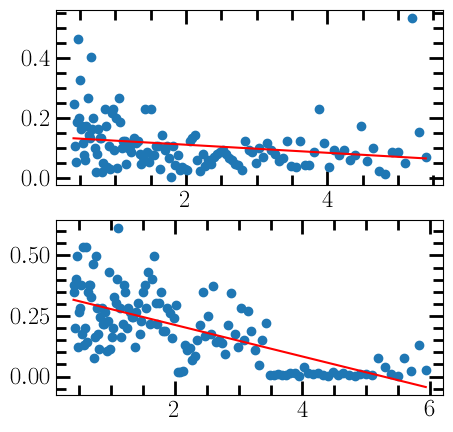

In [102]:
xc = slice_centers[:id_0]
yc = cluster_cut[:id_0]

xf = slice_centers
yf = filament_cut

# fit a linear function to x, y
pc = np.polyfit(xc, yc, 1)
pf = np.polyfit(xf, yf, 1)
# calculate the line equation
linec = np.poly1d(pc)
linef = np.poly1d(pf)

# make a figure with two subplots plotting cluster_cut and filament cut and the fitted line to cluster_cut
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].plot(xc, yc, 'o')
axes[0].plot(xc, line(xc), color='red')
axes[1].plot(xf, filament_cut, 'o')
axes[1].plot(xf, linef(xf), color='red')

In [103]:
cuts = np.logspace(-3, 0, 100) 
log_cuts = np.log(cuts)
log_cuts

array([-6.90775528, -6.83797997, -6.76820467, -6.69842936, -6.62865406,
       -6.55887875, -6.48910344, -6.41932814, -6.34955283, -6.27977753,
       -6.21000222, -6.14022691, -6.07045161, -6.0006763 , -5.930901  ,
       -5.86112569, -5.79135039, -5.72157508, -5.65179977, -5.58202447,
       -5.51224916, -5.44247386, -5.37269855, -5.30292324, -5.23314794,
       -5.16337263, -5.09359733, -5.02382202, -4.95404672, -4.88427141,
       -4.8144961 , -4.7447208 , -4.67494549, -4.60517019, -4.53539488,
       -4.46561957, -4.39584427, -4.32606896, -4.25629366, -4.18651835,
       -4.11674305, -4.04696774, -3.97719243, -3.90741713, -3.83764182,
       -3.76786652, -3.69809121, -3.6283159 , -3.5585406 , -3.48876529,
       -3.41898999, -3.34921468, -3.27943937, -3.20966407, -3.13988876,
       -3.07011346, -3.00033815, -2.93056285, -2.86078754, -2.79101223,
       -2.72123693, -2.65146162, -2.58168632, -2.51191101, -2.4421357 ,
       -2.3723604 , -2.30258509, -2.23280979, -2.16303448, -2.09

## 2.4. Animation

In [ ]:
# Usage Example
images_folder = '/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_FILAMENTS/COSMOS2020-filaments/outputs/plots/allScales_plots'
images_file_names = 'xray-slice*-z=*.png'
output_path = './outputs/plots'
output_filename = 'animation_allScales.mp4'

create_animation_mp4(images_folder, images_file_names, output_path, output_filename, fps=15)

/var/folders/ry/7h2qkbms38q458j803wlq8c80000gp/T/ipykernel_59645/2975709803.py:699: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (4000, 2125) to (4000, 2128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Animation saved as MP4 video to ./outputs/plots/animation_allScales.mp4


# 3. Science

### 3.1. Signal Cut

In [9]:
def fraction_occupied(cut, field):
    """
    Calculates the surface area fraction occupied by areas with signal below "cut" 
    and assigns a binomial error estimate.

    Parameters:
    - cut (float): Signal threshold.
    - field (numpy.ndarray): 2D signal map of shape (mesh_y, mesh_x).

    Returns:
    - frac_occ (float): Fraction of area occupied.
    - error (float): Binomial error associated with the fraction.
    """
    N_total = mesh_x * mesh_y  # Total number of points in the field
    
    frac_occ = np.sum(field < cut) / N_total  # Fraction occupied
    error = np.sqrt(frac_occ * (1 - frac_occ) / N_total)  # Binomial error
    
    return frac_occ, error

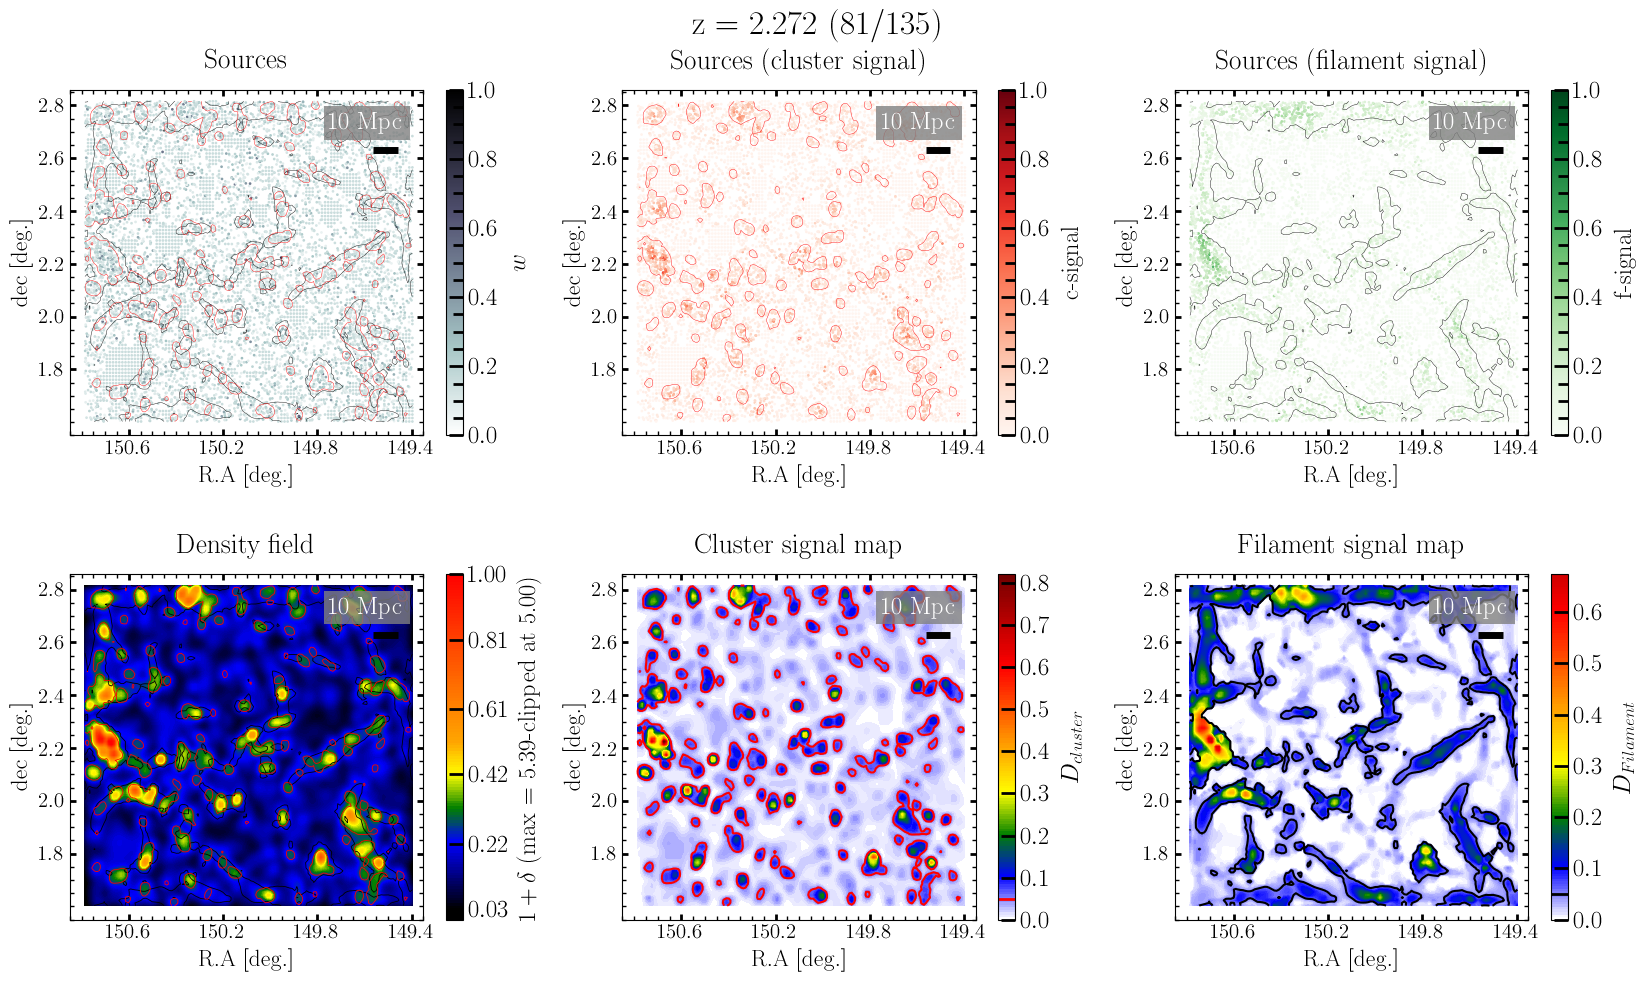

In [108]:
slice = 80
field = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
# field = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
plot_MMF_signalCat(slice, cluster_signal_level = 0.05, filament_signal_level = 0.05, save = False)

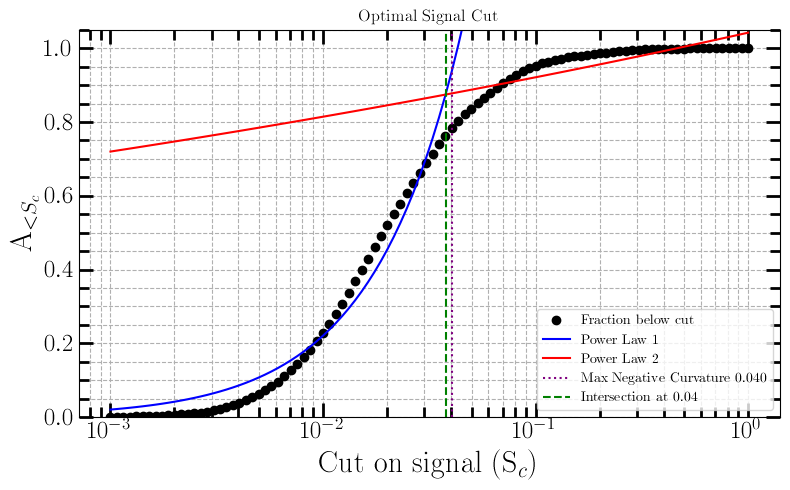

np.float64(0.04037017258596556)

In [109]:
def power_law(x, a, b):
    return a * np.power(x, b)

def find_intersection(x, y1, y2):
    """Find intersection of two curves."""
    f1 = interp1d(x, y1, kind='linear')
    f2 = interp1d(x, y2, kind='linear')
    xnew = np.logspace(np.log10(x.min()), np.log10(x.max()), num=5000)
    ynew1 = f1(xnew)
    ynew2 = f2(xnew)
    idx = np.argwhere(np.diff(np.sign(ynew1 - ynew2))).flatten()
    return xnew[idx]

def detect_change_point(cuts, fraction_occupied, window, signal_field = 'cluster', poly_order=2):
    """
    Detects the transition point where the second derivative of fraction_occupied
    reaches its most negative value, indicating the strongest downward curvature.

    Parameters:
    - cuts: Array of cut values.
    - fraction_occupied: Array of occupied fractions corresponding to each cut.
    - window: Window size for the Savitzky-Golay filter (should be odd).
    - poly_order: Polynomial order for the filter.

    Returns:
    - change_idx: Index where the second derivative is most negative.
    """
    log_cuts = np.log(cuts)
    d2_frac = np.gradient(np.gradient(fraction_occupied, log_cuts), log_cuts)  # Compute second derivative

    # Smooth the second derivative to reduce noise
    d2_frac_smooth = savgol_filter(d2_frac, window_length=window, polyorder=poly_order, mode='nearest')

    change_idx = np.argmin(d2_frac_smooth)  # Most negative curvature point

    return change_idx

def calculate_best_cut(slice, signal_field = 'cluster', window=7, mesh_x=137, mesh_y=120, save = False):
    cuts = np.logspace(-3, 0, 100) 
    
    if signal_field == 'cluster':
        field = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    elif signal_field == 'filament':
        field = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    fraction_occupied = np.array([np.sum(field < cut) / (mesh_x * mesh_y) for cut in cuts])
    
    # Detect the transition point using maximum negative curvature in second derivative
    change_index = detect_change_point(cuts, fraction_occupied, window, poly_order=2)
    # Fit two power-law models before and after the transition point
    params1, _ = curve_fit(power_law, cuts[:change_index], fraction_occupied[:change_index])
    params2, _ = curve_fit(power_law, cuts[change_index:], fraction_occupied[change_index:])
    
    # Find the intersection
    intersection = find_intersection(cuts, power_law(cuts, *params1), power_law(cuts, *params2))
    
    # Plotting
    fig = plt.figure(figsize=(8, 5))
    plt.plot(cuts, fraction_occupied, 'ko', label='Fraction below cut')  # Linear y-scale
    plt.plot(cuts, power_law(cuts, *params1), 'b-', label=r'Power Law 1')
    plt.plot(cuts, power_law(cuts, *params2), 'r-', label=r'Power Law 2')
    plt.axvline(x=cuts[change_index], color='purple', linestyle=':', label=f'Max Negative Curvature {cuts[change_index]:.3f}')
    if len(intersection) > 0:
        plt.axvline(x=intersection[0], color='green', linestyle='--', label=f'Intersection at {intersection[0]:.2f}')
    plt.xscale('log')  # Log scale on x-axis (signal cuts)
    plt.ylim(0, 1.05)
    plt.xlabel(r'Cut on signal (S$_{c}$)')
    plt.ylabel(r'A$_{<S_{c}}$')
    plt.title('Optimal Signal Cut')
    plt.legend()
    plt.grid(True, which="both", linestyle="--")
    fig.tight_layout()
    if save:
        if signal_field == 'cluster':
            plt.savefig(os.path.join(outputs_dir , 'plots/signal_cut/clusterCut-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        elif signal_field == 'filament':
            plt.savefig(os.path.join(outputs_dir , 'plots/signal_cut/filamentCut-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
    
    return cuts[change_index]

calculate_best_cut(slice)